### Wakefield simulation of the LHC unshielded bellows with `wakis`
* Simulation of the Dipolar X impedance and wake
* Creation of the geometry from simple geometry blocks (CSG) -> fully parametrized
* Results varying the PML reflection: 
  
| Wake | Impedance |
| --- | ---------- |
|   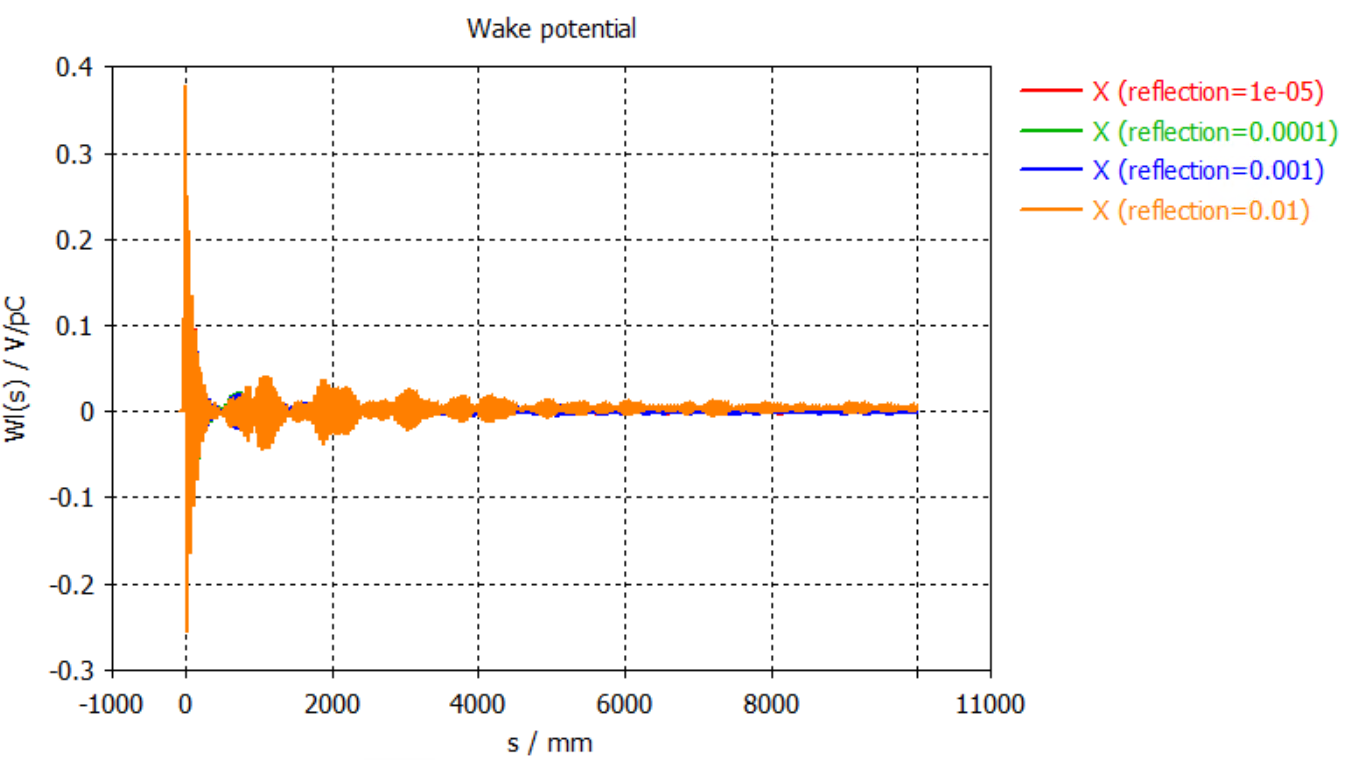  |    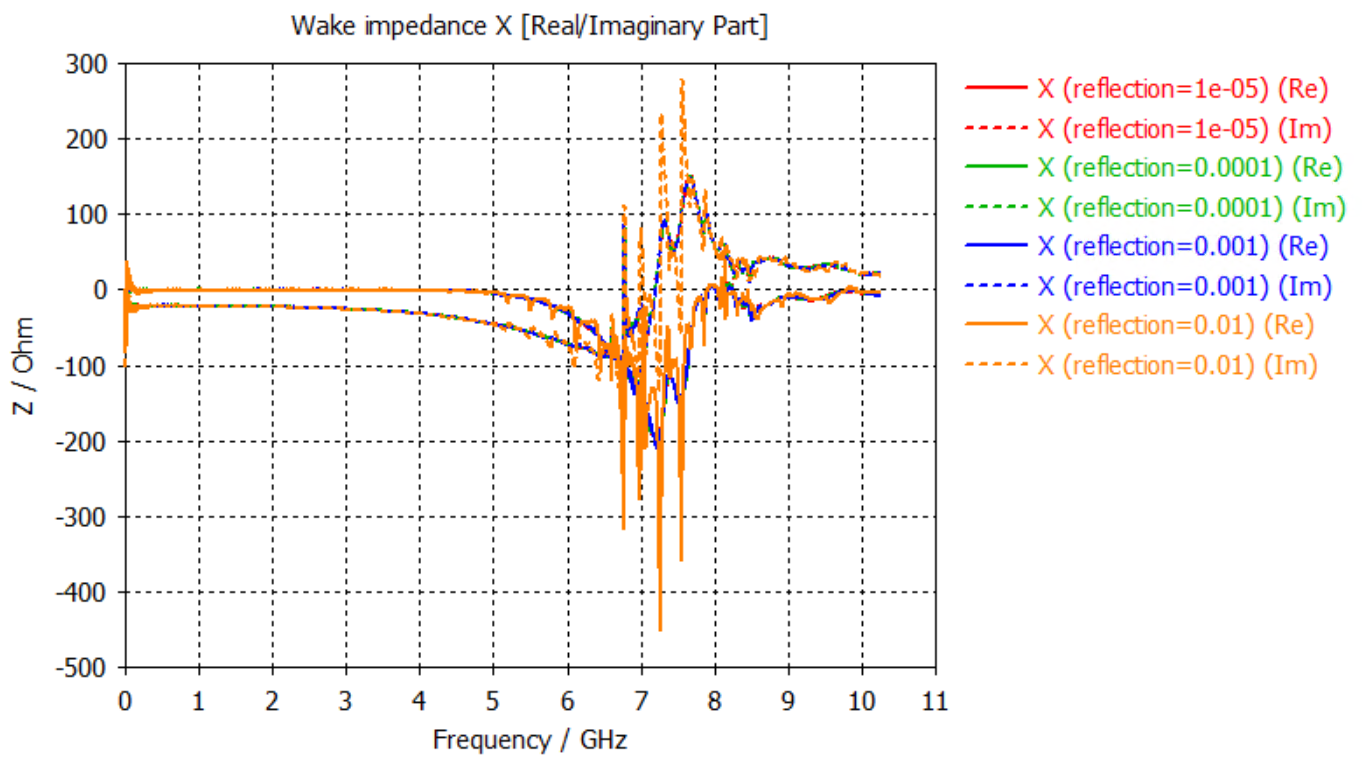        | 

In [2]:
import sys
sys.path.append('../wakis')

In [3]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

%matplotlib ipympl
#pv.set_jupyter_backend('client')

### Construction of the geometry

In [4]:
# beam pipe
r_pipe = 24e-3      # pipe radius [m]
l_pipe = 320e-3     # pipe length [m]
pipe = pv.Cylinder(center=(0,0,0), direction=(0,0,1), radius=r_pipe, height=l_pipe)

# convolutions
r_conv = 30e-3  # convolution radius [m]
l_conv = 4e-3  # length of each convolution [m]
n_conv = 15      # number of convolutions
l_between_conv = 4e-3  # length between convolutions [m]
z_start = n_conv//2*(l_conv + l_between_conv) - l_conv # start of the convolutions [m]
convolutions = []

for n in range(n_conv):
    z_start_n_conv = -z_start+n*(l_conv+l_between_conv)
    conv = pv.Cylinder(center=(0,0,z_start_n_conv),     # center of the convolution
                       direction=(0,0,1),  # z-direction
                       radius=r_conv, 
                       height=l_conv)
    convolutions.append(conv)  # append to list

# Sum the generated geometry
pipe = pipe.triangulate()                          # triangulate pipe
convolutions = np.sum(convolutions).triangulate()  # triangulate convolutions
bellow = pipe + convolutions  # union of meshes without internal faces

# Plot the generated geometry
bellow.clear_data()         # remove tringulation distance data   
#bellow.plot(opacity=0.7)

# Save it to file
stl_file = '011_LHC_Bellows/011_LHC_Bellow_generated.stl'
# bellow.scale(1e3).save(stl_file) #save in [mm]
bellow.save(stl_file) #save in [m]

In [5]:
# Comparison with STL base file
base_stl_file = '011_LHC_Bellows/011_PIMS_Bellow_for_CAS.stl'
base_surf = pv.read(base_stl_file).scale(1e-3)                 # scale from [mm] to [m]
base_surf = base_surf.translate(-1*np.array(base_surf.center)) # center in [0,0,0]
#base_surf.plot()
#base_surf.bounds

if False:
    pl = pv.Plotter()
    pl.add_mesh(base_surf, color='blue', style='wireframe', opacity=0.5, label='base STL')
    pl.add_mesh(bellow, color='green', opacity=0.8, label='generated STL')
    pl.show()

### Snappy mesh test

In [6]:
edges = bellow.extract_feature_edges(boundary_edges=True, manifold_edges=False)

# Extract points lying in the X-Z plane (Y ≈ 0)
xz_plane_points = edges.points[np.abs(edges.points[:, 1]) < 1e-5]
# Extract points lying in the Y-Z plane (X ≈ 0)
yz_plane_points = edges.points[np.abs(edges.points[:, 0]) < 1e-5]
# Extract points lying in the X-Y plane (Z ≈ 0)
xy_plane_points = edges.points[np.abs(edges.points[:, 2]) < 1e-5]

snap_points = np.r_[xz_plane_points, yz_plane_points, xy_plane_points]

# You can now get the unique X and Z coordinates if needed
y_vals = np.unique(np.round(yz_plane_points[:, 1], 5))
x_vals = np.unique(np.round(xz_plane_points[:, 0], 5))
z_vals = np.unique(np.append(np.round(xz_plane_points[:, 2], 5), np.round(yz_plane_points[:, 2], 5)))

# get the unique x, y, z coordinates
#y_snaps = np.unique(np.round(snap_points[:, 1], 5))
#x_snaps = np.unique(np.round(snap_points[:, 0], 5))
#z_snaps = np.unique(np.round(snap_points[:, 2], 5))

print("Snappy vals x:", x_vals)
print("Snappy vals y:", y_vals)
print("Snappy vals z:", z_vals)

# Wrap as a PyVista point cloudz
xz_cloud = pv.PolyData(xz_plane_points)
yz_cloud = pv.PolyData(yz_plane_points)
xy_cloud = pv.PolyData(xy_plane_points)

if False:
    pl = pv.Plotter()
    pl.add_mesh(bellow, color='blue', opacity=0.5, label='base STL')
    pl.add_mesh(edges, color='red', line_width=5, opacity=0.8,)
    pl.add_mesh(xz_cloud, color='green', point_size=20, render_points_as_spheres=True, label='XZ plane points')
    pl.add_mesh(yz_cloud, color='orange', point_size=20, render_points_as_spheres=True, label='YZ plane points')
    #pl.add_mesh(snap_points, color='magenta', point_size=20, render_points_as_spheres=True, label='XY plane points')
    pl.add_legend()
    pl.show()

Snappy vals x: [-0.03  -0.024  0.024  0.03 ]
Snappy vals y: [-0.03  -0.024  0.024  0.03 ]
Snappy vals z: [-0.16  -0.054 -0.05  -0.046 -0.042 -0.038 -0.034 -0.03  -0.026 -0.022
 -0.018 -0.014 -0.01  -0.006 -0.002  0.002  0.006  0.01   0.014  0.018
  0.022  0.026  0.03   0.034  0.038  0.042  0.046  0.05   0.054  0.058
  0.062  0.16 ]


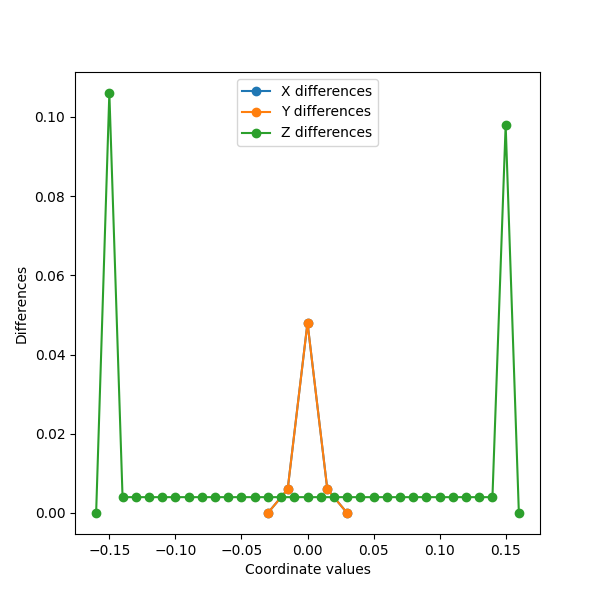

In [7]:
xmin, xmax, ymin, ymax, zmin, zmax = bellow.bounds
x_vals = np.concatenate(([xmin], x_vals, [xmax]))
y_vals = np.concatenate(([ymin], y_vals, [ymax]))
z_vals = np.concatenate(([zmin], z_vals, [zmax]))

diff_x = np.diff(x_vals)
diff_y = np.diff(y_vals)
diff_z = np.diff(z_vals)

plt.figure(figsize=(6, 6))
plt.plot(np.linspace(xmin, xmax, len(diff_x)), diff_x, marker='o', label='X differences')
plt.plot(np.linspace(ymin, ymax, len(diff_y)), diff_y, marker='o', label='Y differences')
plt.plot(np.linspace(zmin, zmax, len(diff_z)), diff_z, marker='o', label='Z differences')
plt.xlabel('Coordinate values')
plt.ylabel('Differences')
plt.legend()

plt.show()

In [8]:
z_vals

array([-0.16 , -0.16 , -0.054, -0.05 , -0.046, -0.042, -0.038, -0.034,
       -0.03 , -0.026, -0.022, -0.018, -0.014, -0.01 , -0.006, -0.002,
        0.002,  0.006,  0.01 ,  0.014,  0.018,  0.022,  0.026,  0.03 ,
        0.034,  0.038,  0.042,  0.046,  0.05 ,  0.054,  0.058,  0.062,
        0.16 ,  0.16 ])

In [9]:
# Minimize length spread in Z-axis
from functools import partial
from scipy.optimize import minimize 

def loss_function(new_points, snaps):
    x = np.sort(np.unique(np.append(snaps, new_points)))
    return np.std(np.diff(x))

Nz = 50
snaps = z_vals
new_points = np.linspace(zmin, zmax, Nz - len(snaps))
objective_function = partial(loss_function, snaps)
result = minimize(objective_function,
                    x0=new_points,
                    bounds=[(zmin, zmax)] * (len(new_points)),
                    #method='Powell', #'Nelder-Mead' is very slow for Nz~300 ~ 1min
                    tol=(zmax-zmin)/len(new_points)*1e-5,
                    options={'maxiter': 1e6,
                            #'maxfev': 1e6,   # only for 'Nelder-Mead'
                            'disp': True,
                            #'adaptive': True # only for 'Nelder-Mead'
                            }
                    )
print("Optimized points:", result.x)
new_axis = np.sort(np.unique(np.append(snaps, result.x)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         2 variables are exactly at the bounds

At iterate    0    f=  7.27723D-03    |proj g|=  3.20000D-01

At iterate    1    f=  7.26279D-03    |proj g|=  6.24444D-02

At iterate    2    f=  7.05853D-03    |proj g|=  5.50138D-02

At iterate    3    f=  6.27647D-03    |proj g|=  1.85081D-02

At iterate    4    f=  6.15647D-03    |proj g|=  1.15115D-02

At iterate    5    f=  6.10779D-03    |proj g|=  6.41279D-03

At iterate    6    f=  6.06434D-03    |proj g|=  7.11213D-03

At iterate    7    f=  6.05632D-03    |proj g|=  1.29183D-02

At iterate    8    f=  6.03335D-03    |proj g|=  1.65871D-03

At iterate    9    f=  6.03292D-03    |proj g|=  2.61772D-04
Optimized points: [-0.1423233  -0.12464776 -0.1069814  -0.08931579 -0.07165754 -0.05200088
 -0.03200001 -0.01199913  0.01199912  0.032       0.05200087  0.07835545
  0.09470234  0.11104862  0.12736953  0.14368998]

In [46]:
from scipy.optimize import least_squares
from functools import partial
def loss_function(new_points, snaps):
    x = np.sort(np.unique(np.append(snaps, new_points)))
    return np.var(np.diff(np.abs(x)))

Nz = 50
snaps = z_vals
new_points = np.random.uniform(zmin, zmax, Nz - len(snaps))
new_points = np.linspace(zmin, zmax, Nz - len(snaps))
objective_function = partial(loss_function, snaps)
result = least_squares(objective_function,
                    x0=new_points,
                    bounds=(zmin, zmax),
                    jac='3-point',
                    method='trf',
                    gtol = 1e-10,
                    #ftol=(zmax-zmin)/len(new_points)*1e-5,
                    )
print("Optimized points:", result.x)
new_axis = np.sort(np.unique(np.append(snaps, result.x)))

Optimized points: [-0.10553614 -0.14130525 -0.12320018 -0.08816749 -0.07104445 -0.04800067
 -0.032      -0.01199955  0.01199955  0.032       0.04800067  0.07733869
  0.09282867  0.12490151  0.14196039  0.10860367]


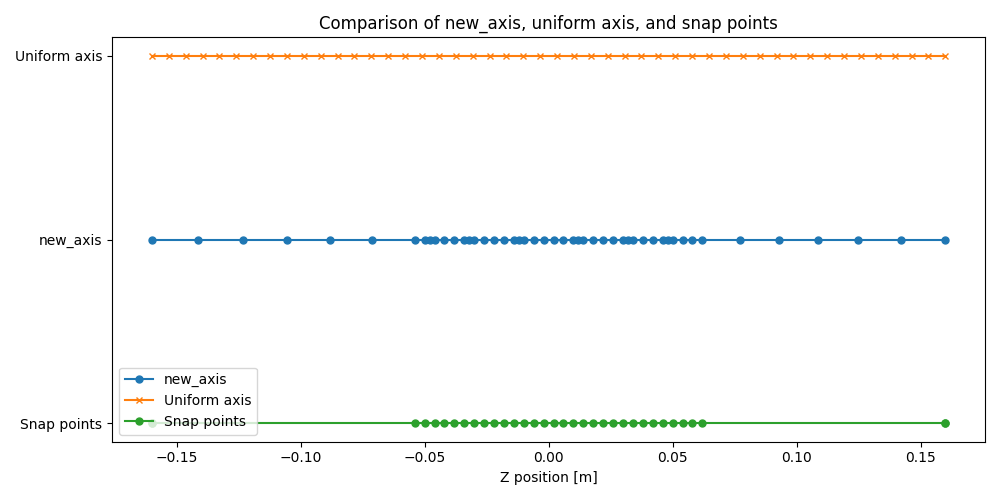

In [47]:
plt.figure(figsize=(10, 5))

# Plot new_axis
plt.plot(new_axis, np.zeros_like(new_axis), '-o', label='new_axis', markersize=5)

# Plot uniformly spaced axis
uniform_axis = np.linspace(zmin, zmax, len(new_axis))
plt.plot(uniform_axis, np.ones_like(uniform_axis), '-x', label='Uniform axis', markersize=5)

# Plot snap points
plt.plot(snaps, np.full_like(snaps, -1), '-o', label='Snap points', markersize=5)

plt.yticks([-1, 0, 1], ['Snap points', 'new_axis', 'Uniform axis'])
plt.xlabel('Z position [m]')
plt.title('Comparison of new_axis, uniform axis, and snap points')
plt.legend()
plt.tight_layout()
plt.show()

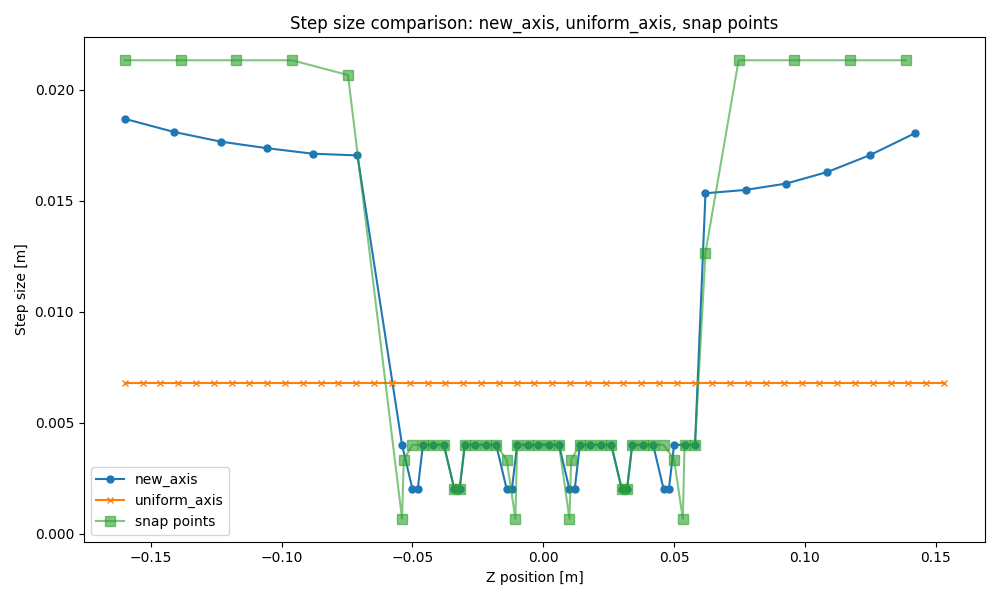

In [48]:
plt.figure(figsize=(10, 6))

# Differences for new_axis
diff_new_axis = np.diff(new_axis)
plt.plot(new_axis[:-1], diff_new_axis, '-o', label='new_axis', markersize=5)

# Differences for uniform_axis
diff_uniform_axis = np.diff(uniform_axis)
plt.plot(uniform_axis[:-1], diff_uniform_axis, '-x', label='uniform_axis', markersize=5)

# Differences for snap points (sorted and unique)
snap_sorted = np.unique(np.append(snaps, np.linspace(zmin, zmax, Nz-len(snaps))))
diff_snaps = np.diff(snap_sorted)
plt.plot(snap_sorted[:-1], diff_snaps, '-s', alpha=0.6, label='snap points', markersize=7)

plt.xlabel('Z position [m]')
plt.ylabel('Step size [m]')
plt.title('Step size comparison: new_axis, uniform_axis, snap points')
plt.legend()
plt.tight_layout()
plt.show()

### Domain setup and grid generation

In [ ]:
# ---------- Domain setup ---------
# Set up geometry & materials dictionaries
stl_solids = {'bellow': stl_file}
stl_materials = {'bellow': 'vacuum'}

# Domain bounds
xmin, xmax, ymin, ymax, zmin, zmax = bellow.bounds

# Number of mesh cells
Nx = 60
Ny = 60
Nz = 220
print(f'Total number of mesh cells: {Nx*Ny*Nz}')

# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz, 
                stl_solids=stl_solids, 
                stl_materials=stl_materials,)

In [ ]:
#pv.set_jupyter_backend('trame')
#grid.inspect()
#grid.plot_solids()

### Boundary conditions and EM solver

In [ ]:
# boundary conditions
bc_low=['pec', 'pec', 'pml']
bc_high=['pec', 'pec', 'pml']

n_pml = 10 # number of PML layers
solver = SolverFIT3D(grid, 
                     bc_low=bc_low, bc_high=bc_high, 
                     use_stl=True, 
                     bg='pec',
                     n_pml=n_pml)

In [ ]:
solver.ieps.inspect(dpi=200, )

### Wakefield settings & Run

The wakefield simulation will run up to 10 m which will give a partially decayed wake and a non-converged impedance - this will be the starting point of IDDEFIX extrapolation !

In [ ]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-3      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 5e-3           # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 


# ----------- Solver  setup  ----------
# Wakefield post-processor
wakelength = 10. # [m] -> Partially decayed
skip_cells = n_pml + 2  # no. cells to skip from wake integration (>= PML cells)
results_folder = '011_LHC_Bellows/011_results/'

wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys, xtest=xt, ytest=yt,
                skip_cells=skip_cells,
                results_folder=results_folder,
                Ez_file=results_folder+'Ez.h5',)

The cell bellow will run the wakefield simulation with the defined beam source and wakelength 

In [ ]:
# Plot settings
import os
if not os.path.exists(results_folder+'img/'): os.mkdir(results_folder+'img/')
plotkw = {'title':results_folder+'img/Ez', 
            'add_patch':'bellow', 'patch_alpha':0.3,
            'vmin':-1e4, 'vmax':1e4,
            'plane': [int(Nx/2), slice(0, Ny), slice(0, Nz)],}

solver.wakesolve(wakelength=wakelength, 
                 wake=wake, 
                 plot=False,
                 plot_every=50, 
                 plot_until=5000,
                 **plotkw)

It's done! Now we can plot the results:

In [ ]:
# plot the Ez field gif
#! convert -delay 5 -loop 0 011_LHC_Bellows/011_results/img/Ez_*.png 011_LHC_Bellows/011_results/img/Ez.gif

In [ ]:
# Recalculate the wake field with a different number of cells to skip
wake.skip_cells = 30
wake.solve()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[12,4], dpi=100)
ax[0].plot(wake.s, wake.WP, c='r', lw=1.5, label='WP Wakis')
ax[0].set_xlabel('s [m]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')

ax[1].plot(wake.f*1e-9, np.real(wake.Z), c='b', lw=1.5, label='Re(Z) Wakis')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), c='b', ls='--', lw=1.5, label='Im(Z) Wakis')
ax[1].legend()
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Re/Im][$\Omega$]', color='b')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[12,4], dpi=100)
ax[0].plot(wake.s, wake.WPx, c='darkgreen', lw=1.5, label='WPx Wakis')
ax[0].set_xlabel('s [m]')
ax[0].set_ylabel('Transverse wake potential X [V/pC]', color='darkgreen')

ax[1].plot(wake.f*1e-9, np.real(wake.Zx), c='g', lw=1.5, label='Re(Zx) Wakis')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zx), c='g', ls='--', lw=1.5, label='Im(Zx) Wakis')
ax[1].legend()
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Transverse impedance X [Re/Im][$\Omega$]', color='g')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[12,4], dpi=100)
ax[0].plot(wake.s, wake.WPy, c='m', lw=1.5, label='WPy Wakis')
ax[0].set_xlabel('s [m]')
ax[0].set_ylabel('Transverse wake potential Y [V/pC]', color='m')

ax[1].plot(wake.f*1e-9, np.real(wake.Zy), c='magenta', lw=1.5, label='Re(Zy) Wakis')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zy), c='magenta', ls='--', lw=1.5, label='Im(Zy) Wakis')
ax[1].legend()
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Transverse impedance Y [Re/Im][$\Omega$]', color='m')

fig.tight_layout()

### Compare with CST

In [ ]:
WP_cst = wake.read_txt('011_LHC_Bellows/dipolar_x_wake.txt')
Zx_cst = wake.read_txt('011_LHC_Bellows/dipolar_x_impedance.txt')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[12,4], dpi=100)

ax[0].plot(WP_cst[0], WP_cst[1], c='k', lw=1.5, label='WPx CST')

ax[0].plot(wake.s*1e3, wake.WPx, c='darkgreen', lw=1.5, alpha=0.5, label='WPx Wakis')
ax[0].set_xlabel('s [mm]')
ax[0].set_ylabel('Transverse wake potential X [V/pC]', color='darkgreen')

ax[1].plot(Zx_cst[0], Zx_cst[1], c='k', lw=1.5, label='Re(Zx) CST')
ax[1].plot(Zx_cst[0], Zx_cst[2], c='k', ls='--', lw=1.5, label='Im(Zx) CST')

ax[1].plot(wake.f*1e-9, np.real(wake.Zx), c='g', alpha=0.5, lw=1.5, label='Re(Zx) Wakis')
ax[1].plot(wake.f*1e-9, -1*np.imag(wake.Zx), c='g', ls='--', alpha=0.5, lw=1.5, label='Im(Zx) Wakis')
ax[1].legend()
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Transverse impedance X [Re/Im][$\Omega$]', color='g')

fig.tight_layout()

We can also calculate the wake function using `iddefix` & `neffint`